In [2]:
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from mne.decoding import CSP
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import make_pipeline
import mne

import moabb
from moabb.datasets import BNCI2014_001
from moabb.evaluations import WithinSessionEvaluation
from moabb.evaluations import CrossSessionEvaluation
from moabb.paradigms import LeftRightImagery


moabb.set_log_level("info")
warnings.filterwarnings("ignore")


In [3]:
##############################################################################
# Instantiating Dataset
# ---------------------
#
# The first thing to do is to instantiate the dataset that we want to analyze.
# MOABB has a list of many different datasets, each one containing all the
# necessary information for describing them, such as the number of subjects,
# size of trials, names of classes, etc.
#
# The dataset class has methods for:
#
# - downloading its files from some online source (e.g. Zenodo)
# - importing the data from the files in whatever extension they might be
#   (like .mat, .gdf, etc.) and instantiate a Raw object from the MNE package

dataset = BNCI2014_001()
dataset.subject_list = [1, 2, 3]

In [4]:
##############################################################################
# Accessing EEG Recording
# -----------------------
#
# As an example, we may access the EEG recording from a given session and a
# given run as follows:

sessions = dataset.get_data(subjects=[1])

##############################################################################
# This returns a MNE Raw object that can be manipulated. This might be enough
# for some users, since the pre-processing and epoching steps can be easily
# done via MNE. However, to conduct an assessment of several classifiers on
# multiple subjects, MOABB ends up being a more appropriate option.

subject = 1
session_name = "0train"
run_name = "0"
raw = sessions[subject][session_name][run_name]

In [5]:
print(raw.info)

<Info | 8 non-empty values
 bads: []
 ch_names: Fz, FC3, FC1, FCz, FC2, FC4, C5, C3, C1, Cz, C2, C4, C6, CP3, ...
 chs: 22 EEG, 3 EOG, 1 Stimulus
 custom_ref_applied: False
 dig: 25 items (3 Cardinal, 22 EEG)
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 26
 projs: []
 sfreq: 250.0 Hz
>


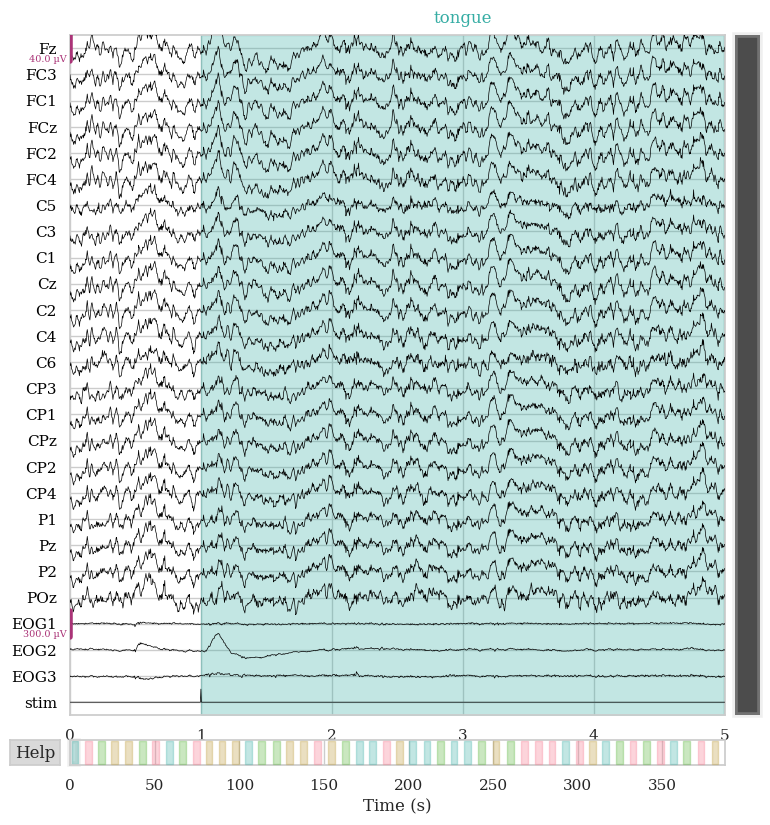

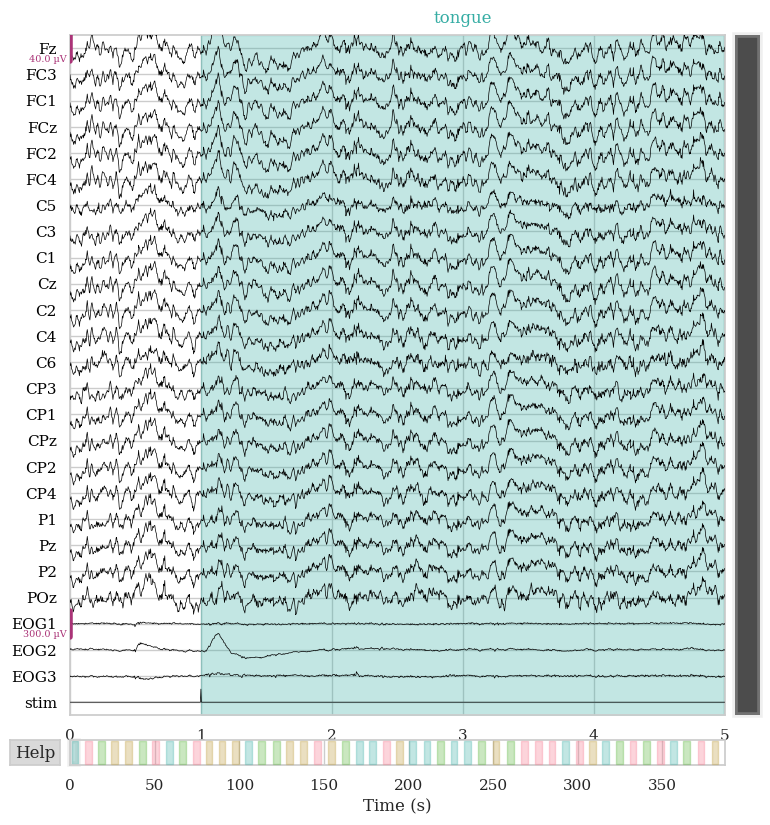

In [6]:
raw.plot(duration=5, n_channels=30)

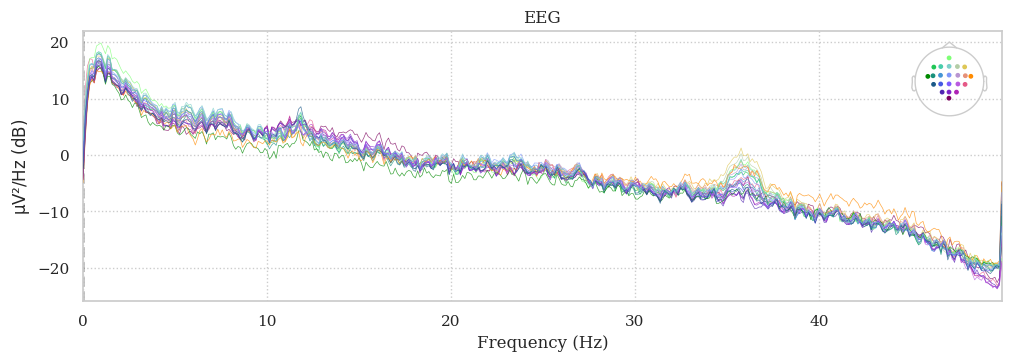

In [7]:
raw.compute_psd(fmax=50).plot()

In [8]:
# set up and fit the ICA
ica = mne.preprocessing.ICA(n_components=20, random_state=97, max_iter=800)


Not setting metadata
193 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
193 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
193 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
193 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
193 matching events found
No baseline correction applied
0 projection items activated


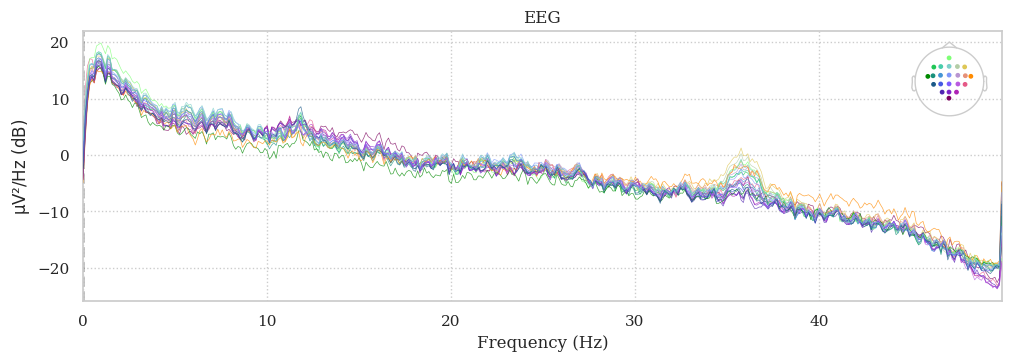

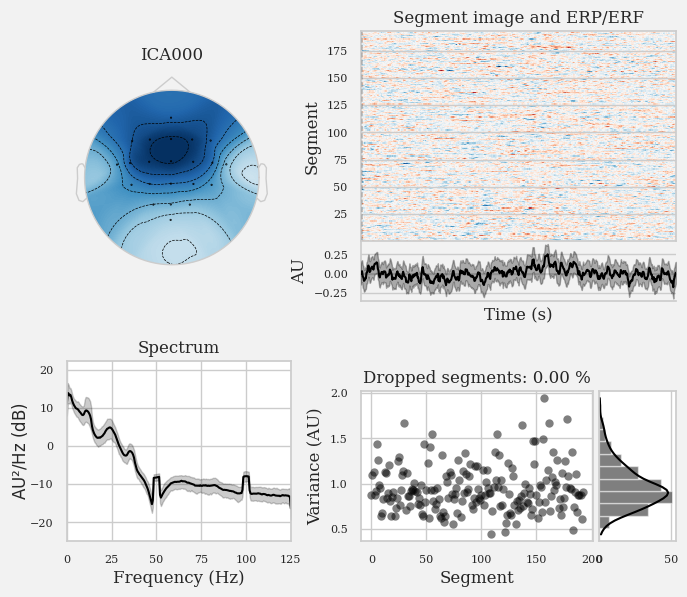

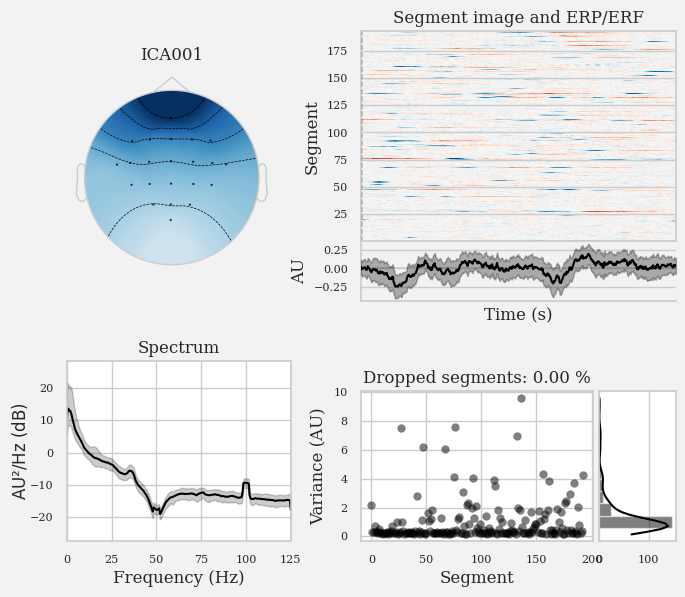

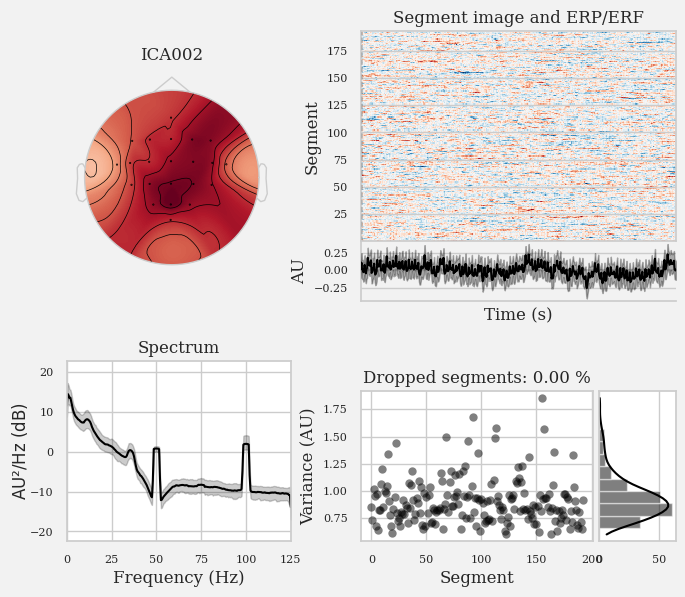

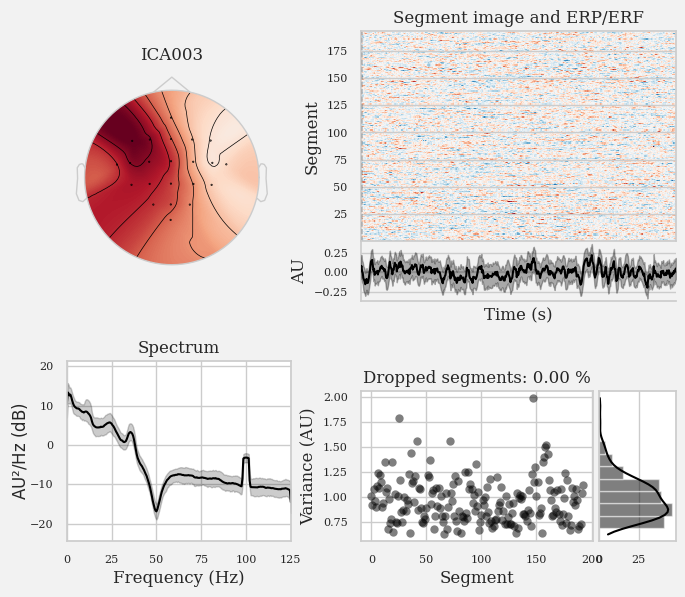

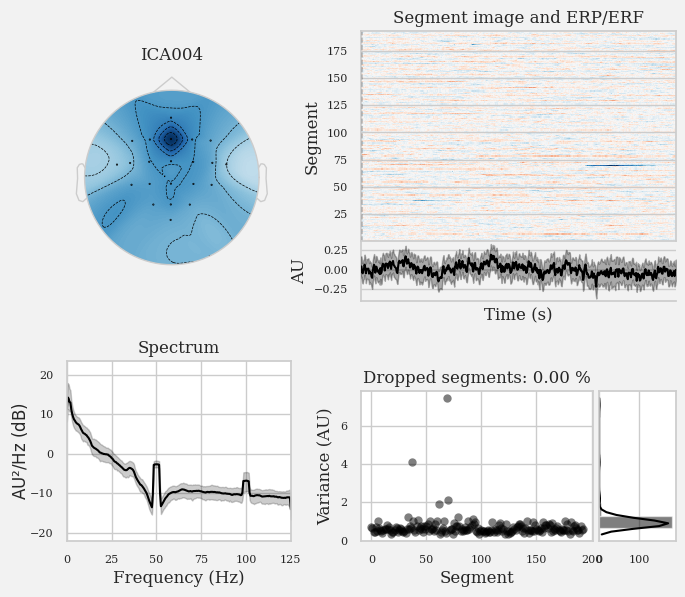

[<Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>]

In [9]:
ica.fit(raw)
ica.plot_properties(raw)

In [10]:
##############################################################################
# Choosing a Paradigm
# -------------------
#
# Once we have instantiated a dataset, we have to choose a paradigm. This
# object is responsible for filtering the data, epoching it, and extracting
# the labels for each epoch. Note that each dataset comes with the names of
# the paradigms to which it might be associated. It would not make sense to
# process a P300 dataset with a MI paradigm object.

print(dataset.paradigm)



imagery


In [11]:
##############################################################################
# For the example below, we will consider the paradigm associated to
# left-hand/right-hand motor imagery task, but there are other options in
# MOABB for motor imagery, P300 or SSVEP.

paradigm = LeftRightImagery()

##############################################################################
# We may check the list of all datasets available in MOABB for using with this
# paradigm (note that BNCI2014_001 is in it)

print(paradigm.datasets)

[<moabb.datasets.bnci.BNCI2014_001 object at 0x00000285EDD44250>, <moabb.datasets.bnci.BNCI2014_004 object at 0x000002858BB8DE20>, <moabb.datasets.gigadb.Cho2017 object at 0x000002858BB0B8E0>, <moabb.datasets.mpi_mi.GrosseWentrup2009 object at 0x000002858C2DF2E0>, <moabb.datasets.Lee2019.Lee2019_MI object at 0x00000285ED9DC9A0>, <moabb.datasets.physionet_mi.PhysionetMI object at 0x000002858181B7F0>, <moabb.datasets.schirrmeister2017.Schirrmeister2017 object at 0x000002858B91A220>, <moabb.datasets.bbci_eeg_fnirs.Shin2017A object at 0x000002858C01D160>, <moabb.datasets.Weibo2014.Weibo2014 object at 0x00000285EA7854F0>, <moabb.datasets.Zhou2016.Zhou2016 object at 0x0000028581851E50>]


In [12]:
print(paradigm.get_data(dataset=dataset, subjects=[1]))

(array([[[  6.12675343,   4.80069492,   1.8937593 , ...,  -1.80963356,
          -0.95822005,   0.10018214],
        [  5.58056783,   3.78074325,   1.02786715, ...,  -1.32946883,
          -0.62293255,   0.06768451],
        [  7.43279059,   5.46171881,   2.11057866, ...,  -0.57576039,
          -0.65376666,  -0.73565678],
        ...,
        [  7.465582  ,   3.39468294,  -1.15504664, ...,  -3.41820391,
          -2.94795975,  -2.31999583],
        [  5.00811146,   1.58727604,  -2.11582106, ...,  -3.48512891,
          -2.69524861,  -1.68924441],
        [  8.01582351,   4.2274779 ,  -0.1410632 , ...,  -4.097163  ,
          -3.54158428,  -2.65380789]],

       [[ -0.7702083 ,  -0.77995427,  -1.51378905, ...,  -9.44448146,
         -11.03344346, -11.02605606],
        [ -1.33536169,  -1.04522174,  -0.87003607, ...,  -8.77443588,
         -10.72309939, -10.2110244 ],
        [  0.30316772,   0.02742408,  -1.01425588, ...,  -9.24718849,
         -11.26148117, -10.91802947],
        ...,

In [13]:
##############################################################################
# The data from a list of subjects could be preprocessed and return as a 3D
# numpy array `X`, follow a scikit-like format with the associated `labels`.
# The `meta` object contains all information regarding the subject, the
# session and the run associated to each trial.
X, labels, meta = paradigm.get_data(dataset=dataset, subjects=[1])

In [14]:
print(X.shape, labels.shape, meta)

(288, 22, 1001) (288,)      subject session run
0          1  0train   0
1          1  0train   0
2          1  0train   0
3          1  0train   0
4          1  0train   0
..       ...     ...  ..
283        1   1test   5
284        1   1test   5
285        1   1test   5
286        1   1test   5
287        1   1test   5

[288 rows x 3 columns]


In [15]:
##############################################################################
# Create Pipeline
# ---------------
#
# Our goal is to evaluate the performance of a given classification pipeline
# (or several of them) when it is applied to the epochs from the previously
# chosen dataset. We will consider a very simple classification pipeline in
# which the dimension of the epochs are reduced via a CSP step and then
# classified via a linear discriminant analysis.

pipeline = make_pipeline(CSP(n_components=8), LDA())

In [16]:
##############################################################################
# Evaluation
# ----------
#
# To evaluate the score of this pipeline, we use the `evaluation` class. When
# instantiating it, we say which paradigm we want to consider, a list with the
# datasets to analyze, and whether the scores should be recalculated each time
# we run the evaluation or if MOABB should create a cache file.
#
# Note that there are different ways of evaluating a classifier; in this
# example, we choose `WithinSessionEvaluation`, which consists of doing a
# cross-validation procedure where the training and testing partitions are from
# the same recording session of the dataset. We could have used
# `CrossSessionEvaluation`, which takes all but one session as training
# partition and the remaining one as testing partition.

evaluation = WithinSessionEvaluation(
    paradigm=paradigm,
    datasets=[dataset],
    overwrite=True,
    hdf5_path=None,
)



In [17]:
##############################################################################
# We obtain the results in the form of a pandas dataframe

results = evaluation.process({"csp+lda": pipeline})

2024-05-31 14:01:05,485 INFO MainThread moabb.evaluations.base Processing dataset: BNCI2014-001
BNCI2014-001-WithinSession:   0%|          | 0/3 [00:00<?, ?it/s]

No hdf5_path provided, models will not be saved.


2024-05-31 14:01:14,413 INFO MainThread moabb.evaluations.base csp+lda | BNCI2014-001 | 1 | 0train: Score 0.915


No hdf5_path provided, models will not be saved.


2024-05-31 14:01:16,673 INFO MainThread moabb.evaluations.base csp+lda | BNCI2014-001 | 1 | 1test: Score 0.940
BNCI2014-001-WithinSession:  33%|███▎      | 1/3 [00:11<00:23, 11.59s/it]

No hdf5_path provided, models will not be saved.


2024-05-31 14:01:29,803 INFO MainThread moabb.evaluations.base csp+lda | BNCI2014-001 | 2 | 0train: Score 0.643


No hdf5_path provided, models will not be saved.


2024-05-31 14:01:32,053 INFO MainThread moabb.evaluations.base csp+lda | BNCI2014-001 | 2 | 1test: Score 0.687
BNCI2014-001-WithinSession:  67%|██████▋   | 2/3 [00:27<00:13, 13.89s/it]

No hdf5_path provided, models will not be saved.


2024-05-31 14:01:41,699 INFO MainThread moabb.evaluations.base csp+lda | BNCI2014-001 | 3 | 0train: Score 0.987


No hdf5_path provided, models will not be saved.


2024-05-31 14:01:43,758 INFO MainThread moabb.evaluations.base csp+lda | BNCI2014-001 | 3 | 1test: Score 0.991
BNCI2014-001-WithinSession: 100%|██████████| 3/3 [00:38<00:00, 12.88s/it]


In [18]:
##############################################################################
# The results are stored in locally, to avoid recomputing the results each time.
# It is saved in `hdf5_path` if defined or in ~/mne_data/results  otherwise.
# To export the results in CSV:

results.to_csv("./results_part2-1.csv")

##############################################################################
# To load previously obtained results saved in CSV

results = pd.read_csv("./results_part2-1.csv")



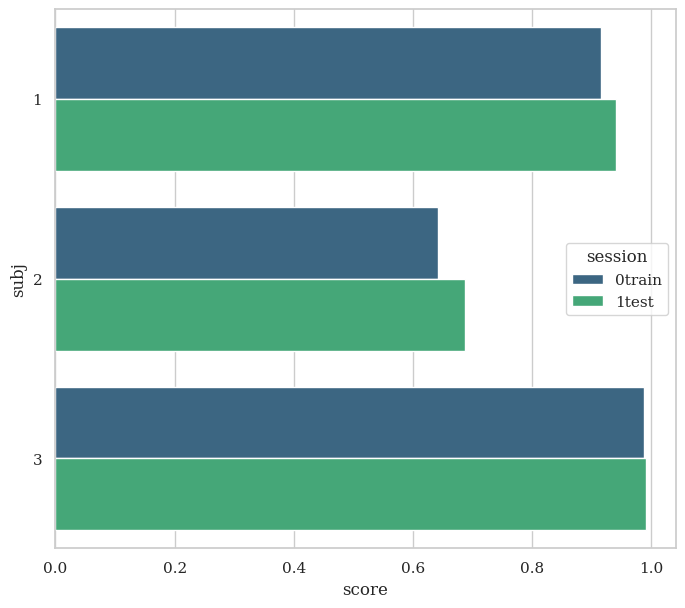

In [19]:
##############################################################################
# Plotting Results
# ----------------
#
# We create a figure with the seaborn package comparing the classification
# score for each subject on each session. Note that the 'subject' field from
# the `results` is given in terms of integers, but seaborn accepts only
# strings for its labeling. This is why we create the field 'subj'.

fig, ax = plt.subplots(figsize=(8, 7))
results["subj"] = results["subject"].apply(str)
sns.barplot(
    x="score", y="subj", hue="session", data=results, orient="h", palette="viridis", ax=ax
)
plt.show()